<a href="https://colab.research.google.com/github/nataliaiglesiasbueno/UFV_visualizacion_datos/blob/main/clase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Práctica 1**

Natalia Iglesias Bueno

Ingeniería Matemática - 4º A

# **Introducción**

# **Datos**
* **COUNTRY** = país
* **SUBBRAND** = marca del producto
* **YEAR** = año
* **MONTH** = mes
* **SCENARIO** =
    * Actual significa que es una venta que se produjo real, mientras que forecast es una predicción que se hizo en otra fecha pero para esa fecha. Es decir, la fecha de FORECAST y FORECAST_YEAR indica cuando se hizo la predicción y la fecha para la cual se hizo está predicción viene indicada por YEAR y MONTH. Si el escenario es actual, FORECAST y FORECAST_YEAR estarán vacíos, ya que estos campos indican cuando se hizo la predicción y en este caso no existe una.
* **FORECAST** = mes en la que se ha realizado la predicción
* **FORECAST_YEAR** = año en que se hah realizado la predicción
* **AMOUNT** = datos de venta / cantidad vendida


Horizonte de previsión = cuantos puntos predices en cada ejecución. Tengo que saber desde cuando tengo forecast.

Necesito saber a partir de cuando tengo datos y para qué países.

#### **Importación librerias**

In [427]:
import plotly.express as px
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [428]:
!pip install plotly_express

### **Cargar base de datos**

In [429]:
from google.colab import files
uploaded = files.upload()

Saving datos_ejercicio_ventas.csv to datos_ejercicio_ventas (4).csv


In [430]:
nombres_columnas = ['COUNTRY', 'SUBBRAND','YEAR','MONTH','SCENARIO','FORECAST','FORECAST_YEAR','AMOUNT']

df = pd.read_csv('/content/datos_ejercicio_ventas.csv', header=None, skiprows=1)
df.columns = nombres_columnas
df_copia = df.copy()

In [431]:
df.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,754356.237194
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023.0,560030.558029
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847
3,Great Britain,7up (L3),2024,12,AI_forecast,AI_P10F,2023.0,363224.511516
4,Hungary,Lipton (L3),2023,9,AI_forecast,AI_P03F,2023.0,396176.120491


# **Limpieza base de datos**

### **Analizar los posibles escenarios**

Al observar los valores en la columna SCENARIO, vemos que hay **dos posibles casos**: **actual**, indicando las ventas reales que se han producido y, **AI_Forecast**, lo cual representa una predicción realizada para esa fecha (aunque la propia predicción se hiciera en otro momento).

Hay una **gran diferencia entre el número de registros con actual y aquellos con AI_forecast**. Solo 900 registros corresponden a ventas reales (actual), lo cual es relativamente bajo en comparación con el volumen total de datos. La mayoría de los datos (17,766 registros) son predicciones (AI_forecast), por lo que parece que la base de datos está compuesta principalmente de datos estimados para el futuro en lugar de ventas realizadas.

Esto puede ser una **limitación para analizar las tendencias** de compras llevadas a cabo o estudios sobre el comportamiento real del mercado, ya que la mayoría de los datos no corresponden a ventas efectivamente realizadas. Por lo tanto, para estudiar aspectos como la distribución de las ventas o su tendencia y estacionalidad, no se van a tener en cuenta los datos correspondientes a predicciones ya que introduciría sesgo en los resultados e interpretaciones de ellos.

Sin embargo, sí que se analizarán posteriormente en el punto 3, para saber cuales son las predicciones hechas en España y la precisión de estas predicciones para evaluar si representan adecuadamente las ventas futuras.



In [432]:
forecast_counts = df['SCENARIO'].value_counts()
forecast_counts[['actual', 'AI_forecast']] # Filtrar estos dos valores

,count
SCENARIO,
actual,900
AI_forecast,17766


### **Cantidad de países**

Se observa que hay un total de 9 países. Gran Bretaña tiene la mayor cantidad de registros (4008), lo cual indica una fuerte presencia de más del 20% en el mercado. Otros países como Países Bajos, Hungría, Dinamarca, España y Noruega también tienen un alto número de registros, teniendo una presencia similar en el mercado.

Italia, en cambio, tiene el menor número de registros (708) y representa solamente el 4% del mercado. Por lo tanto, al analizar los datos habrá que tener en cuenta esta distribución y el impacto de cada país en el mercado para evitar sesgos.

In [433]:
paises_counts = df['COUNTRY'].value_counts()
num_paises = len(paises_counts)

print("Número total de países:")
num_paises

Número total de países:


9

In [434]:
paises_counts

,count
COUNTRY,
Great Britain,4008
Netherlands,2476
Hungary,2384
Denmark,2294
Spain,2152
Norway,2062
Czech,1403
Portugal,1179
Italy,708


La siguiente distribución representa los porcentajes de países que tienen más registros, pero no necesariamente siempre los países con mayor total de ventas (como veremos en el apartado 1 de la práctica).

In [435]:
# Calcular el porcentaje de registros por país
country_counts = df['COUNTRY'].value_counts(normalize=True) * 100
country_counts_df = country_counts.reset_index()
country_counts_df.columns = ['COUNTRY', 'PERCENTAGE']

fig = px.bar(
    country_counts_df,
    x='COUNTRY',
    y='PERCENTAGE',
    title='Distribución de registros por País',
    labels={'COUNTRY': 'País', 'PERCENTAGE': 'Porcentaje (%)'},
    text='PERCENTAGE'
)

# Ajustar el formato del texto en las barras
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    title={
        'text': 'Distribución de registros por País',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)

fig.show()

### **Cantidad de productos**

Se observa que existen 6 tipos de productos distintos. El producto **Pepsi Max** domina claramente con una presencia de más del 30% de todos los registros, indicando que es una de las marcas más representadas en el dataset.
Sin embargo, **Mountain Dew** tiene la menor cantidad de registros, equivalente al 8% de los productos, por lo que esta marca tiene una presencia más limitada en comparación con otras marcas. Esta información se podría utilizar para entender las preferencias de los consumidores.

In [436]:
productos_counts = df['SUBBRAND'].value_counts()
num_productos = len(productos_counts)

print("Número total de productos:")
num_productos

Número total de productos:


6

In [437]:
productos_counts

,count
SUBBRAND,
Pepsi Max (L3),5598
Pepsi Regular (L3),3636
7up (L3),2694
Lipton (L3),2693
7up Free (L3),2343
Mountain Dew (L3),1702


In [438]:
# Calcular el porcentaje de registros por submarca
subbrand_counts = df['SUBBRAND'].value_counts(normalize=True) * 100
subbrand_counts_df = subbrand_counts.reset_index()
subbrand_counts_df.columns = ['SUBBRAND', 'PERCENTAGE']

fig = px.bar(
    subbrand_counts_df,
    x='SUBBRAND',
    y='PERCENTAGE',
    title='Distribución de registros por Marca',
    labels={'SUBBRAND': 'Marca', 'PERCENTAGE': 'Porcentaje (%)'},
    text='PERCENTAGE'
)

fig.update_layout(
    title={
        'text': 'Distribución de registros por Marca',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.show()

In [439]:
print(df.dtypes)

COUNTRY           object
SUBBRAND          object
YEAR               int64
MONTH              int64
SCENARIO          object
FORECAST          object
FORECAST_YEAR    float64
AMOUNT           float64
dtype: object


# **Horizonte de Previsión**

La variable scenario puede ser actual o AI_forecast. Si es actual, forecast y forecast_year estarán vacíos, ya que estos campos indican cuándo se hizo la predicción y en ese caso no hay una. Actual significa que es una venta que se produjo real.  La variable forecast y forecast year es la fecha en la que se hizo la prediccion, mientras que la fecha para la cual se hizo la predicción está en year y month. El mes que se le asigna como que interpreta cada valor de forecast se explicará posteriormente.

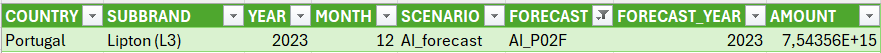

Por ejemplo, la fila de la imagen representa que en febrero de 2023, se hizo una previsión de lo que iba a vender el producto Lipton de Portugal en diciembre del 2023. El horizonte de prevision es el número de puntos que se tienen (desde la primera predicción hasta la final). En este caso el horizonte sería 12.


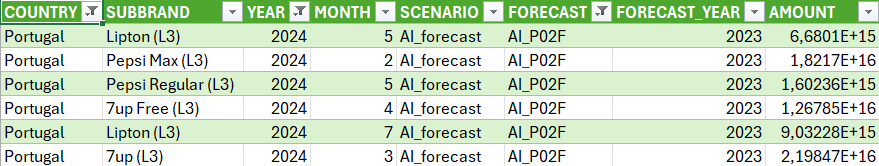

Sin embargo, como se ve en la imagen de arriba, en un mismo mes se han hecho predicciones para distintas fechas. Por lo tanto, el horizonte de prevision debe de ser el que más lejos llegue. Todos los países tienen el mismo horizonte de prevision.




In [440]:
# Filtrar los datos para el país Portugal
spain_forecasts = df[df['COUNTRY'] == 'Spain']

# Mapear los códigos de predicción a los meses
forecast_month_mapping = {
    'AI_PF': 1, 'AI_P02F': 2, 'AI_P03F': 3, 'AI_P04F': 4,
    'AI_P05F': 5, 'AI_P06F': 6, 'AI_P07F': 7, 'AI_P08F': 8,
    'AI_P09F': 9, 'AI_P10F': 10, 'AI_P11F': 11, 'AI_P12F': 12
}

# Añadir la columna de mes en el que se hizo la predicción
spain_forecasts['FORECAST_MONTH'] = spain_forecasts['FORECAST'].map(forecast_month_mapping)

<ipython-input-440-06d866d624df>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [441]:
spain_forecasts['DATE'] = pd.to_datetime(spain_forecasts[['YEAR', 'MONTH']].assign(DAY=1))

spain_forecasts['FORECAST_MONTH'] = pd.to_numeric(spain_forecasts['FORECAST_MONTH'], errors='coerce').astype('Int64')
spain_forecasts['FORECAST_YEAR'] = pd.to_numeric(spain_forecasts['FORECAST_YEAR'], errors='coerce').astype('Int64')

spain_forecasts['DATE_FORECAST'] = pd.to_datetime(spain_forecasts['FORECAST_YEAR'].astype(str) + '-' + spain_forecasts['FORECAST_MONTH'].astype(str), format='%Y-%m', errors='coerce')

<ipython-input-441-a7cbd191799f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-441-a7cbd191799f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-441-a7cbd191799f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-441-a7c

In [442]:
spain_forecasts

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,FORECAST_MONTH,DATE,DATE_FORECAST
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023,88501.980847,9,2023-12-01,2023-09-01
20,Spain,Pepsi Regular (L3),2023,12,AI_forecast,AI_P05F,2023,134268.151080,5,2023-12-01,2023-05-01
25,Spain,Lipton (L3),2025,3,AI_forecast,AI_P11F,2023,9702.217953,11,2025-03-01,2023-11-01
62,Spain,7up Free (L3),2024,1,AI_forecast,AI_P04F,2023,70144.329753,4,2024-01-01,2023-04-01
68,Spain,7up (L3),2024,4,AI_forecast,AI_P02F,2023,38882.921227,2,2024-04-01,2023-02-01
...,...,...,...,...,...,...,...,...,...,...,...
18599,Spain,7up Free (L3),2023,9,actual,NaN,<NA>,75888.808279,<NA>,2023-09-01,NaT
18611,Spain,Pepsi Regular (L3),2024,1,AI_forecast,AI_P07F,2023,107080.159342,7,2024-01-01,2023-07-01
18617,Spain,Pepsi Max (L3),2024,10,AI_forecast,AI_P07F,2023,96728.475541,7,2024-10-01,2023-07-01
18653,Spain,Pepsi Regular (L3),2024,3,AI_forecast,AI_P09F,2023,120652.827718,9,2024-03-01,2023-09-01


In [443]:
spain_pred = spain_forecasts[spain_forecasts['SCENARIO']=='AI_forecast']

In [444]:
spain_pred

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,FORECAST_MONTH,DATE,DATE_FORECAST
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023,88501.980847,9,2023-12-01,2023-09-01
20,Spain,Pepsi Regular (L3),2023,12,AI_forecast,AI_P05F,2023,134268.151080,5,2023-12-01,2023-05-01
25,Spain,Lipton (L3),2025,3,AI_forecast,AI_P11F,2023,9702.217953,11,2025-03-01,2023-11-01
62,Spain,7up Free (L3),2024,1,AI_forecast,AI_P04F,2023,70144.329753,4,2024-01-01,2023-04-01
68,Spain,7up (L3),2024,4,AI_forecast,AI_P02F,2023,38882.921227,2,2024-04-01,2023-02-01
...,...,...,...,...,...,...,...,...,...,...,...
18585,Spain,Pepsi Regular (L3),2024,10,AI_forecast,AI_P10F,2023,163326.763411,10,2024-10-01,2023-10-01
18611,Spain,Pepsi Regular (L3),2024,1,AI_forecast,AI_P07F,2023,107080.159342,7,2024-01-01,2023-07-01
18617,Spain,Pepsi Max (L3),2024,10,AI_forecast,AI_P07F,2023,96728.475541,7,2024-10-01,2023-07-01
18653,Spain,Pepsi Regular (L3),2024,3,AI_forecast,AI_P09F,2023,120652.827718,9,2024-03-01,2023-09-01


In [445]:
date_count_per_forecast = spain_pred.groupby('DATE_FORECAST')['DATE'].nunique().reset_index()

date_count_per_forecast.columns = ['DATE_FORECAST', 'UNIQUE_DATE_COUNT']

horizonte = date_count_per_forecast['UNIQUE_DATE_COUNT'].max()

print("El horizonte de previsión es", horizonte)


El horizonte de previsión es 18


### **Histórico de los Actuals**

En la gráfica de los datos actual:

* La barra más alta corresponde a febrero de 2024, con un valor de 46 registros.
* La barra más baja corresponde a enero de 2023, con un valor de 44 registros.

La **variación entre el valor máximo y mínimo es pequeña**, por lo que se entiende que los registros actual se mantienen bastante **constantes** a lo largo del tiempo.

In [446]:
# Separar los datos segun el escenario
actual_data = df[df['SCENARIO'] == 'actual'].groupby(['YEAR', 'MONTH']).size()
forecast_data = df[df['SCENARIO'] == 'AI_forecast'].groupby(['YEAR', 'MONTH']).size()

# Encontrar el valor máximo y mínimo en el conjunto de datos 'actual_data'
max_value = actual_data.max()
min_value = actual_data.min()

# Identificar las fechas correspondientes al valor máximo y mínimo
max_date = actual_data.idxmax()
min_date = actual_data.idxmin()

print(f"Cantidad máximo de registros de valores reales es {max_value} en {max_date} ")
print(f"Cantidad mínima de registros de valores reales es {min_value} en {min_date} ")

Cantidad máximo de registros de valores reales es 46 en (2024, 2) 
Cantidad mínima de registros de valores reales es 44 en (2023, 1) 


In [447]:
import plotly.express as px
import pandas as pd

# Crear la columna DATE a partir de YEAR y MONTH
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))

# Contar la cantidad de registros por fecha
actual_data_count = df[df['SCENARIO'] == 'actual'].groupby('DATE').size().reset_index(name='COUNT')

fig = px.bar(
    actual_data_count,
    x='DATE',
    y='COUNT',
    title='Histórico de Datos reales (Actual)',
    labels={'DATE': 'Fecha', 'COUNT': 'Número de Registros'},
    color_discrete_sequence=['navy']
)

fig.update_layout(
    title={
        'text': 'Histórico de Datos Reales (Actual)',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)
fig.show()

### **Histórico de las predicciones**

En la gráfica de los datos forecast:

* La barra más alta corresponde a diciembre de 2023, con un valor de 987 registros.
* La barra más baja corresponde a enero de 2023, con un valor de 71 registros.

Los registros de las predicciones se distribuyen como una normal. A medida que las **predicciones se extienden en el tiempo, la incertidumbre aumenta**, por lo que se generen **menos predicciones a medida que se alejan del presente**. Por eso, la cantidad de predicciones es mayor en 2023 y 2024 (a corto y medio plazo, llegando a su peak en 2024), donde el modelo aún puede ofrecer una precisión razonable, mientras que disminuye en 2025, donde las predicciones podrían ser menos confiables.

Sin embargo, aunque en 2023 el número de predicciones va creciendo a medida que pasa el tiempo, en los primero meses de 2023 no hay tantos registros como en 2024. Esto puede ser debido al año en que se encuentra en ese momento. Todos los valores de forecast_year tiene valor 2023. Esto significa que todas las predicciones se han realizado en ese año. Dado que 2023 era el momento actual, puede que no haya sido necesario generar tantas predicciones para los meses restantes del año y hayan preferido **enfocarse en prever el futuro** en lugar de hacer proyecciones detalladas para un año en curso, especialmente si ya hay datos disponibles de ventas reales.




In [448]:
# Encontrar el valor máximo y mínimo en el conjunto de datos 'forecast_data'
max_value_forecast = forecast_data.max()
min_value_forecast = forecast_data.min()

# Identificar las fechas correspondientes al valor máximo y mínimo
max_date_forecast = forecast_data.idxmax()
min_date_forecast = forecast_data.idxmin()

print(f"Cantidad máximo de registros de valores predichos es {max_value_forecast} en {max_date_forecast} ")
print(f"Cantidad mínima de registros de valores predichos es {min_value_forecast} en {min_date_forecast} ")

Cantidad máximo de registros de valores predichos es 987 en (2023, 12) 
Cantidad mínima de registros de valores predichos es 71 en (2023, 1) 


In [449]:
# Agrupar los datos de 'forecast' por YEAR y MONTH y contar el número de registros
forecast_data_count = df[df['SCENARIO'] == 'AI_forecast'].groupby(['YEAR', 'MONTH']).size().reset_index(name='COUNT')

# Crear la columna DATE a partir de YEAR y MONTH para el eje X
forecast_data_count['DATE'] = pd.to_datetime(forecast_data_count[['YEAR', 'MONTH']].assign(DAY=1))

fig = px.bar(
    forecast_data_count,
    x='DATE',
    y='COUNT',
    title='Histórico de Datos Predichos (Forecast)',
    labels={'DATE': 'Fecha', 'COUNT': 'Número de Registros'},
    color_discrete_sequence=['navy']
)

fig.update_layout(
    title={
        'text': 'Histórico de Datos Predichos (Forecast)',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)
fig.show()

### **Análisis coherencia de los valores de las variables**
 Puntos que se van a tratar:
 * Valores negativos en AMOUNT
 * Renombrar los meses

In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18666 entries, 0 to 18665
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   COUNTRY        18666 non-null  object        
 1   SUBBRAND       18666 non-null  object        
 2   YEAR           18666 non-null  int64         
 3   MONTH          18666 non-null  int64         
 4   SCENARIO       18666 non-null  object        
 5   FORECAST       17766 non-null  object        
 6   FORECAST_YEAR  17766 non-null  float64       
 7   AMOUNT         18666 non-null  float64       
 8   DATE           18666 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 1.3+ MB


**Puntos que se han observado y son coherentes:**

* FORECAST_YEAR = solo tiene un único valor (2023), ya que todas las predicciones se hicieron en ese año.
* MONTH toma valores desde 1 a 12 y YEAR desde 2023 a 2025, por lo que hay registros entre esos dos años en la base de datos.
* Cuando el escenario es actual, el año solo toma valores 2023 y 2024, lo cual tiene sentido ya que son ventas ya realizadas y no a futuro. Por lo tanto, el único caso en el que el año puede ser 2025 es si el escenario es una predicción.

**Puntos a modificar:**

* AMOUNT = este valor representa la cantidad vendida de un producto en litros, por lo que no puede ser negativo, ya que implicaría vender una cantidad negativa de un producto. Por lo tanto estos valores se deben eliminar. Tampoco tendría sentido que el valor fuese 0 ya que entonces no se habría realizado ninguna compra.

In [451]:
numeric_summary = df.describe()
numeric_summary

,YEAR,MONTH,FORECAST_YEAR,AMOUNT,DATE
count,18666.000000,18666.000000,17766.0,1.866600e+04,18666
mean,2023.716383,6.475463,2023.0,9.721822e+05,2024-03-03 18:27:57.917068544
min,2023.000000,1.000000,2023.0,-2.171201e+05,2023-01-01 00:00:00
25%,2023.000000,3.000000,2023.0,8.754541e+04,2023-10-01 00:00:00
50%,2024.000000,6.000000,2023.0,3.081759e+05,2024-03-01 00:00:00
75%,2024.000000,9.000000,2023.0,1.078576e+06,2024-08-01 00:00:00
max,2025.000000,12.000000,2023.0,1.481563e+07,2025-05-01 00:00:00
std,0.590782,3.463632,0.0,1.915283e+06,NaN


#### **Eliminar datos negativos de la variable amount**

In [452]:
# Eliminar filas donde la variable 'AMOUNT' tenga valores negativos
df = df[df['AMOUNT'] > 0]

# Verificar que no hay valores negativos en 'AMOUNT' después de la eliminación
negative_values_check = (df['AMOUNT'] <= 0).any()
print("¿Hay valores negativos o igual a cero en 'AMOUNT' después de la eliminación? ----> ", negative_values_check)


¿Hay valores negativos o igual a cero en 'AMOUNT' después de la eliminación? ---->  False


Comprobación

In [453]:
numeric_summary = df.describe()
numeric_summary

,YEAR,MONTH,FORECAST_YEAR,AMOUNT,DATE
count,17920.000000,17920.000000,17030.0,1.792000e+04,17920
mean,2023.710212,6.485714,2023.0,1.012668e+06,2024-03-01 19:43:25.178571520
min,2023.000000,1.000000,2023.0,4.438089e-01,2023-01-01 00:00:00
25%,2023.000000,3.000000,2023.0,1.046553e+05,2023-10-01 00:00:00
50%,2024.000000,6.000000,2023.0,3.638737e+05,2024-03-01 00:00:00
75%,2024.000000,9.000000,2023.0,1.137650e+06,2024-08-01 00:00:00
max,2025.000000,12.000000,2023.0,1.481563e+07,2025-05-01 00:00:00
std,0.589078,3.453181,0.0,1.944225e+06,NaN


### **Renombrar los meses**

Se van a renombrar los meses, de forma que no aparezca con letras para mayor facilidad del análisis y visualización posterior de los gráficos.

Inicialmente se pensaba que los meses estaban registrados de la siguiente forma:
* AI_P02F = enero
* AI_P03F = febrero
* AI_P04F = marzo
* .......
* AI_P012F = noviembre
* AI_PF = diciembre

Sin embargo, tras hacer varias comprobaciones, se ha llegado a la conclusión de que no es exactamente así porque de esta forma se estarían haciendo predicciones sobre el pasado.

**Comprobación:**

En la siguiente imagen, se ha sustituido AI_PF por su mes que se pensaba que era (diciembre). Sin embargo, no puede ser que en diciembre se hagan predicciones de todos los meses anteriores de ese mismo 2023.

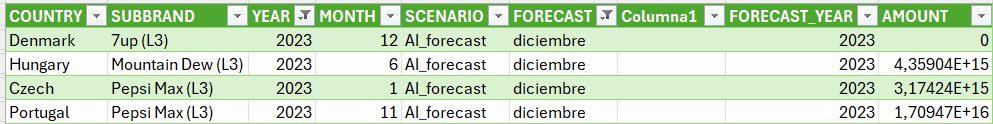


Pero renombrando los meses de la siguiente forma sí que tiene coherencia:

* AI_PF = enero
* AI_P02F = febrero
* AI_P03F = marzo
* AI_P04F = abril
* AI_P05F = mayo
* AI_P06F = junio
* AI_P07F = julio
* AI_P08F = agosto
* AI_P09F = septiembre
* AI_P10F = octubre
* AI_P11F = noviembre
* AI_P12F = diciembre

**Antes se estaba considerando la predicción hecha como el último día del mes, pero en este caso se está considerando como si fuera el día 1.**

Por ejemplo, cuando se están realizando predicciones en febrero, se deberían realizar desde febrero en adelante. En este caso, MONTH puede tomar valores desde 2 hasta 12, con lo cual es coherente. Si lo comprobamos con otros meses, todos son coherentes: en marzo toma valores desde 3 hasta 12, en abril desde 4 hasta 12...y así sucesivamente.

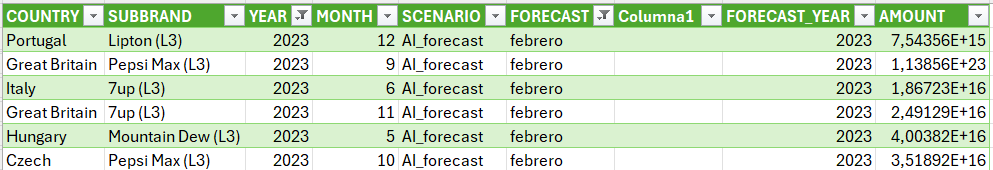


Por lo tanto, se van a renombrar los meses de esta forma pero en inglés para mantener el mismo idioma en toda la base de datos.

In [454]:
forecast_rename = {
    'AI_P01F': 'January',
    'AI_P02F': 'February',
    'AI_P03F': 'March',
    'AI_P04F': 'April',
    'AI_P05F': 'May',
    'AI_P06F': 'June',
    'AI_P07F': 'July',
    'AI_P08F': 'August',
    'AI_P09F': 'September',
    'AI_P10F': 'October',
    'AI_P11F': 'November',
    'AI_P12F': 'December'
}

# Aplicar el renombrado a la columna 'FORECAST'
df['FORECAST'] = df['FORECAST'].replace(forecast_rename)
df.head()


,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,DATE
0,Portugal,Lipton (L3),2023,12,AI_forecast,February,2023.0,754356.237194,2023-12-01
1,Great Britain,Lipton (L3),2023,12,AI_forecast,October,2023.0,560030.558029,2023-12-01
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,September,2023.0,88501.980847,2023-12-01
3,Great Britain,7up (L3),2024,12,AI_forecast,October,2023.0,363224.511516,2024-12-01
4,Hungary,Lipton (L3),2023,9,AI_forecast,March,2023.0,396176.120491,2023-09-01


Por lo tanto, ya se ha analizado las categorías que pueden tomar las variables COUNTRY y SUBBRAND, así como la coherencia entre las fechas de los valores actuales y predicciones. También se ha evaluado la coherencia de los valores que puede tomar AMOUNT.
Una vez terminada la limpieza, se pasa a realizar los apartados de la práctica.

# **APARTADO 1 : Distribución de las ventas**

A continuación, se va a estudiar la distribución de las ventas respecto a país, marca, mes y año.



# **1.1 - Distribución de Ventas por País**





**Cálculo de los porcentajes de la venta de cada país**

In [455]:
# Filtrar solo las ventas reales (asumiendo que se identifican por la columna 'SCENARIO' como 'actual')
real_sales = df[df['SCENARIO'] == 'actual']

# Agrupar ventas por país y calcular el total de ventas de todos los países
country_sales = real_sales.groupby('COUNTRY')['AMOUNT'].sum().reset_index()
total_sales_all_countries = country_sales['AMOUNT'].sum()

# Calcular el porcentaje de ventas de cada país y añadirlo como una columna
country_sales['Percentage'] = (country_sales['AMOUNT'] / total_sales_all_countries) * 100

# Renombrar las columnas para mayor claridad
country_sales.columns = ['País', 'Ventas Totales', 'Porcentaje']
country_sales['Porcentaje'] = country_sales['Porcentaje'].round(2)

# Ordenar la tabla por la columna 'Ventas Totales' de mayor a menor
country_sales = country_sales.sort_values(by='Ventas Totales', ascending=False).reset_index(drop=True)

Creo la columna del porcentaje invertido para luego poder añadirlo a la gráfica.

Pero el porcentaje correcto de cada país es el de la columna Porcentaje.

Es decir, simplemente se usa para la visualización del gráfico de barras.

In [456]:
country_sales['Porcentaje_Invertido'] = country_sales['Porcentaje'][::-1].values
country_sales

,País,Ventas Totales,Porcentaje,Porcentaje_Invertido
0,Great Britain,3.347786e+08,49.95,1.21
1,Netherlands,6.395943e+07,9.54,5.21
2,Denmark,5.659668e+07,8.45,5.27
3,Norway,5.143697e+07,7.68,6.20
4,Italy,4.345404e+07,6.48,6.48
5,Hungary,4.157947e+07,6.20,7.68
6,Czech,3.535164e+07,5.27,8.45
7,Portugal,3.488807e+07,5.21,9.54
8,Spain,8.131266e+06,1.21,49.95


In [457]:
fig_country = px.bar(
    country_sales.sort_values(by='Ventas Totales'),
    x='Ventas Totales', y='País',
    title='Distribución de Ventas por País',
    labels={'Ventas Totales': 'Total de Ventas', 'País': 'País'},
    orientation='h',
    text=country_sales['Porcentaje_Invertido'].astype(str) + '%'
)

fig_country.update_layout(
    title={
        'text': 'Distribución de Ventas por País',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)

# Ajustar la posición y formato del texto para que sea más claro
fig_country.update_traces(textposition='outside')
fig_country.show()

Esta gráfica muestra las **partes del total de ventas totales por país**, ordenada de mayor a menor.

* **Great Britain** se destaca significativamente, con aproximadamente el **49.95% del total de ventas**. Esto implica que casi la mitad de las ventas provienen de este país, lo que lo convierte en el mercado más importante con gran diferencia. La alta concentración de ventas en Great Britain indica una **dependencia fuerte en un solo mercado**. Esto puede ser una ventaja en términos de volumen, pero también representa un riesgo si las condiciones de mercado en este país cambian desfavorablemente (regulaciones, crisis económica, etc.).
* Los países siguientes en importancia son **Netherlands** y **Denmark**, con un 9.54% y 8.45% respectivamente, aunque su participación es mucho menor comparada con la de Great Britain.
* **Norway**, **Italy**, **Hungary**, y **Czech** tienen porcentajes de ventas en el rango de 5% a 8%, lo cual sugiere una contribución moderada pero relevante en comparación con el total.
* **Portugal** y **Spain** se encuentran al final de la lista, con **5.21% y 1.21%** respectivamente. Especialmente **Spain**, con el porcentaje más bajo, representa una fracción mínima del total de ventas. Estos países de baja participación podrían tener menor relevancia estratégica en términos de ventas, o podrían ser regiones con potencial de crecimiento si se invierte en su desarrollo de mercado.


# **1.2 - Distribución de Ventas por Mes y Año**


In [458]:
# Crear una columna de fecha para facilitar el análisis temporal
real_sales['DATE'] = pd.to_datetime(real_sales[['YEAR', 'MONTH']].assign(DAY=1))

# Agrupar ventas por mes y año
monthly_sales = real_sales.groupby('DATE')['AMOUNT'].sum().reset_index()

fig_month_year = px.line(
    monthly_sales,
    x='DATE', y='AMOUNT',
    title='Evolución de Ventas por Mes y Año',
    labels={'AMOUNT': 'Total de Ventas', 'DATE': 'Fecha'},
)

fig_month_year.update_layout(
    title={
        'text': 'Evolución de Ventas por Mes y Año',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)

# Añadir puntos en cada mes para facilitar la visualización
fig_month_year.update_traces(mode='lines+markers')

# Añadir círculos (sin relleno) en los puntos de abril 2023, 2024 y enero 2024 (rojos)
highlight_dates_red = [
    pd.Timestamp('2023-04-01'),
    pd.Timestamp('2024-04-01'),
    pd.Timestamp('2024-01-01')
]

# Añadir círculos (sin relleno) en los puntos de agosto de ambos años y diciembre 2023 (verdes)
highlight_dates_green = [
    pd.Timestamp('2023-08-01'),
    pd.Timestamp('2024-08-01'),
    pd.Timestamp('2023-12-01')
]

# Dibujar los círculos rojos
for date in highlight_dates_red:
    y_value = monthly_sales.loc[monthly_sales['DATE'] == date, 'AMOUNT'].values[0]
    fig_month_year.add_shape(
        type='circle',
        xref='x', yref='y',
        x0=date - pd.DateOffset(days=5),  # Ajustar horizontalmente
        y0=y_value - (y_value * 0.01),  # Ajustar verticalmente
        x1=date + pd.DateOffset(days=5),  # Ajustar horizontalmente
        y1=y_value + (y_value * 0.01),  # Ajustar verticalmente
        line=dict(color='red', width=2, dash='solid')
    )

# Dibujar los círculos verdes
for date in highlight_dates_green:
    y_value = monthly_sales.loc[monthly_sales['DATE'] == date, 'AMOUNT'].values[0]
    fig_month_year.add_shape(
        type='circle',
        xref='x', yref='y',
        x0=date - pd.DateOffset(days=5),  # Ajustar horizontalmente
        y0=y_value - (y_value * 0.01),  # Ajustar verticalmente
        x1=date + pd.DateOffset(days=5),  # Ajustar horizontalmente
        y1=y_value + (y_value * 0.01),  # Ajustar verticalmente
        line=dict(color='green', width=2, dash='solid')
    )

# Añadir anotaciones para la leyenda en la esquina inferior derecha
fig_month_year.add_annotation(
    x=monthly_sales['DATE'].max(), y=monthly_sales['AMOUNT'].min(),
    text="⬤ Pico alto",
    showarrow=False,
    font=dict(color='green'),
    xanchor='right',  # Alinear el texto a la derecha
    yanchor='bottom',  # Alinear el texto en la parte inferior
    xshift=-5,  # Ajustar la posición horizontal
    yshift=10    # Ajustar la posición vertical
)

fig_month_year.add_annotation(
    x=monthly_sales['DATE'].max(), y=monthly_sales['AMOUNT'].min() * 1.05,
    text="⬤ Pico bajo",
    showarrow=False,
    font=dict(color='red'),
    xanchor='right',  # Alinear el texto a la derecha
    yanchor='bottom',  # Alinear el texto en la parte inferior
    xshift=-1,  # Ajustar la posición horizontal
    yshift=5    # Ajustar la posición vertical
)
fig_month_year.show()

<ipython-input-458-5a7a1ab2e3c7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Esta gráfica de líneas muestra la **evolución de ventas mensuales** a lo largo de los años 2023 y 2024, sin hacer una separación por países.


* Tendencia:
  - Las ventas mensuales no siguen una tendencia constante. En cambio, presentan subidas y bajadas notables, lo que indica que la demanda es bastante variable a lo largo del tiempo. Hay picos en ciertos meses, como **abril de 2023**, **agosto de 2023**, y **agosto de 2024**, donde se registran aumentos significativos en las ventas.

  - La segunda mitad de 2023 muestra una ligera tendencia de caída hasta fin de año, mientras que el inicio de 2024 muestra una recuperación en ventas. Es decir, existe un patrón de caída al final del año y recuperación al inicio del siguiente, lo cual podría indicar una **estacionalidad en las ventas**.

#### **Explicación mínimos**

* La disminución de refrescos durante diciembre puede ser por varias razones:
  - Las personas pueden preferir **bebidas específicas de temporada** (como vinos, champán, o licores) para las celebraciones, en lugar de las bebidas regulares que se venden el resto del año. Esto podría afectar a las ventas de bebidas como refrescos, té o productos no alcohólicos, reduciendo las ventas entre diciembre y enero.

  - Por otro lado, a la hora de realizar las **compras para navidad** en cuanto a comida y bebidas, las personas **lo suelen hacer con tiempo**. Por lo que tiene sentido que a principios de diciembre haya un pico, y vaya bajando hasta enero, alcanzando en este momento un mínimo. Después de las festividades, muchas personas tienden a reducir el consumo de productos como bebidas azucaradas o refrescos en enero para tratar de adoptar hábitos de consumo más saludables, lo cual también podría impactar negativamente en las ventas de estos productos.

  Aunque agosto es el máximo, en el mes de marzo también hay un aumento de ventas.


#### **Explicación máximos**

El pico de ventas en agosto se debe a una combinación de factores de **clima cálido, aumento del turismo, mayor tiempo libre, etc.**, lo cual hace que agosto sea el mes en el cual se consumen más bebidas. Aunque julio y junio también son meses de verano, agosto concentra una mayor cantidad de personas en actividades de ocio y viajes, especialmente en países donde es el principal mes de vacaciones. Además, en destinos turísticos, la cantidad que hay de turistas suele ser muy alta en agosto, lo cual incrementa la demanda de bebidas en restaurantes, bares, hoteles, y otros establecimientos. La combinación de altas temperaturas y vacaciones hace que las personas prefieran consumir bebidas frías, lo cual aumenta las ventas de refrescos.


Además, agosto suele ser un mes con festivales, conciertos y eventos al aire libre donde se consumen más bebidas de lo habitual. También en entornos familiares o con amigos, donde las personas suelen consumir más bebidas en barbacoas, picnics, o fiestas.


#### **Explicación bajada abril**

La caída de ventas de marzo a abril en el sector de bebidas puede ser por varias razones:

   - Marzo suele ser un mes de mayor actividad debido a eventos como el inicio de la primavera en muchos países, así como la celebración de algunas festividades (por ejemplo, el Día de San Patricio en algunos países anglosajones, que aumenta el consumo de bebidas). En abril, después de este período de eventos y festividades, es común que el consumo disminuya, ya que las personas tienden a regresar a sus rutinas normales y a moderar el gasto y el consumo.


A continuación, se realiza la misma gráfica anterior pero concretamente para Great Britain (el país más dominante en las ventas).

In [459]:
# Crear una columna de fecha para facilitar el análisis temporal
real_sales['DATE'] = pd.to_datetime(real_sales[['YEAR', 'MONTH']].assign(DAY=1))

# Agrupar ventas por mes, año y país
monthly_sales_country = real_sales.groupby(['DATE', 'COUNTRY'])['AMOUNT'].sum().reset_index()

# Filtrar las ventas de Great Britain
great_britain_sales = monthly_sales_country[monthly_sales_country['COUNTRY'] == 'Great Britain']

fig_gb = px.line(
    great_britain_sales,
    x='DATE', y='AMOUNT',
    title='Evolución de Ventas en Great Britain',
    labels={'AMOUNT': 'Total de Ventas', 'DATE': 'Fecha'}
)
fig_gb.update_traces(mode='lines+markers')

fig_gb.update_layout(
    title={
        'text': 'Evolución de Ventas en Great Britain',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)

# Ajustar el eje Y para que esté bien distribuido
min_y_value = great_britain_sales['AMOUNT'].min() * 0.9  # Reducir un poco el mínimo
max_y_value = great_britain_sales['AMOUNT'].max() * 1.1  # Aumentar un poco el máximo
fig_gb.update_yaxes(range=[min_y_value, max_y_value])

# Añadir círculos (sin relleno) en fechas específicas
highlight_dates_red = [
    pd.Timestamp('2023-04-01'),
    pd.Timestamp('2024-04-01'),
    pd.Timestamp('2024-01-01')
]

highlight_dates_green = [
    pd.Timestamp('2023-08-01'),
    pd.Timestamp('2024-08-01'),
    pd.Timestamp('2023-12-01'),
    pd.Timestamp('2023-05-01'),
    pd.Timestamp('2024-05-01')
]

# Dibujar los círculos rojos
for date in highlight_dates_red:
    if date in great_britain_sales['DATE'].values:
        y_value = great_britain_sales.loc[great_britain_sales['DATE'] == date, 'AMOUNT'].values[0]
        fig_gb.add_shape(
            type='circle',
            xref='x', yref='y',
            x0=date - pd.DateOffset(days=5),
            y0=y_value - (y_value * 0.01),
            x1=date + pd.DateOffset(days=5),
            y1=y_value + (y_value * 0.01),
            line=dict(color='red', width=2, dash='solid')
        )

# Dibujar los círculos verdes
for date in highlight_dates_green:
    if date in great_britain_sales['DATE'].values:
        y_value = great_britain_sales.loc[great_britain_sales['DATE'] == date, 'AMOUNT'].values[0]
        fig_gb.add_shape(
            type='circle',
            xref='x', yref='y',
            x0=date - pd.DateOffset(days=5),
            y0=y_value - (y_value * 0.01),
            x1=date + pd.DateOffset(days=5),
            y1=y_value + (y_value * 0.01),
            line=dict(color='green', width=2, dash='solid')
        )

# Añadir anotaciones para la leyenda en la esquina inferior derecha
fig_gb.add_annotation(
    x=great_britain_sales['DATE'].max(), y=min_y_value,
    text="⬤ Pico alto",
    showarrow=False,
    font=dict(color='green', size=12),
    xanchor='right',
    yanchor='bottom',
    xshift=-6,
    yshift=25
)

fig_gb.add_annotation(
    x=great_britain_sales['DATE'].max(), y=min_y_value * 1.1,
    text="⬤ Pico bajo",
    showarrow=False,
    font=dict(color='red', size=12),
    xanchor='right',
    yanchor='bottom',
    xshift=-2,
    yshift=10
)
fig_gb.show()

<ipython-input-459-5f3acd78e1a1>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



La gráfica y tendencia de Great Britain es prácticamente igual que el gráfico anterior donde se consideraban las ventas por mes y año en general (independientemente del país). Por lo tanto, se ve el efecto que tiene este país sobre la distribución de las ventas de todos los países, ya que este representa una mayoría. Sin embargo, en Great Britain se ve un pico alto en mayo, que en el gráfico de líneas de todos los países no era tan marcado.

### **Histograma y variaciones de las ventas entre 2023 y 2024**

In [460]:
# Agrupar las ventas por mes y año y calcular el total de ventas mensuales
monthly_sales = real_sales.groupby(['YEAR', 'MONTH'])['AMOUNT'].sum().reset_index()

# Pivotar la tabla para tener los años como columnas y calcular la variación porcentual entre 2023 y 2024
monthly_sales_pivot = monthly_sales.pivot(index='MONTH', columns='YEAR', values='AMOUNT')
monthly_sales_pivot['Variation (%)'] = ((monthly_sales_pivot[2024] - monthly_sales_pivot[2023]) / monthly_sales_pivot[2023]) * 100

print("Variación de Ventas Mensuales entre 2023 y 2024:")
print(monthly_sales_pivot)

Variación de Ventas Mensuales entre 2023 y 2024:
YEAR           2023          2024  Variation (%)
MONTH                                           
1      2.808880e+07  2.689110e+07      -4.263974
2      2.610437e+07  2.989003e+07      14.502005
3      3.593163e+07  3.449766e+07      -3.990835
4      3.085725e+07  3.369920e+07       9.209996
5      3.690245e+07  3.677264e+07      -0.351766
6      3.759999e+07  3.508763e+07      -6.681814
7      3.403860e+07  3.571656e+07       4.929591
8      3.817477e+07  3.855704e+07       1.001365
9      3.216776e+07           NaN            NaN
10     3.144918e+07           NaN            NaN
11     3.291774e+07           NaN            NaN
12     3.483175e+07           NaN            NaN


In [461]:
# Crear una lista ordenada de los meses en español
meses_ordenados = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                   'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Reemplazar los números de los meses por nombres en español
real_sales['MONTH_NAME'] = real_sales['MONTH'].replace({
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio',
    7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
})

# Asegurarse de que los datos estén ordenados por año y mes
real_sales = real_sales.sort_values(by=['YEAR', 'MONTH'])

fig_hist = px.histogram(
    real_sales,
    x='MONTH_NAME', y='AMOUNT',
    color='YEAR',
    category_orders={'MONTH_NAME': meses_ordenados},  # Ordenar los meses correctamente
    barmode='group',
    title='Histograma de Distribución de Ventas por Mes y Año',
    labels={'AMOUNT': 'Total de Ventas', 'MONTH_NAME': 'Mes', 'YEAR': 'Año'},
    color_discrete_sequence=["#4A90E2", "#003366"]  # Azul claro y azul oscuro
)

fig_hist.update_layout(
    title={
        'text': 'Histograma de Distribución de Ventas por Mes y Año',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    },
    yaxis_title='Total de Ventas'  # Cambiar el título del eje Y
)

fig_hist.show()

<ipython-input-461-3e85ffc4f4f8>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Aunque se observa variación en las ventas mensuales entre 2023 y 2024, destaca especialmente el mes de febrero con un incremento notable del 14.5%. Este aumento podría estar relacionado con promociones que impulsaron la demanda en 2024. Además, el mes de abril muestra un aumento significativo del 9.21%, lo que sugiere una posible estrategia para aumentar las ventas en este mes, ya que se había visto en el gráfico de líneas anterior que las ventas en este mes suelen disminuir. El mes de junio también experimenta una disminución del 6.68%. Sin embargo, la variación en los demás meses se mantiene por debajo del 5%, lo que indica una fluctuación menor y una estabilidad relativa entre los dos años en la mayoría de los meses. Esto sugiere que, **salvo algunos picos puntuales, las ventas mensuales no presentan cambios drásticos entre 2023 y 2024.**

## **Correlación entre las ventas de 2023 y 2024**

In [462]:
df = df_copia

In [463]:
# Crear una lista ordenada de los meses en español
meses_ordenados = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                   'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Crear un DataFrame de ventas promedio por mes y año
monthly_avg_sales = df[df['SCENARIO'] == 'actual'].groupby(['YEAR', 'MONTH']).agg({'AMOUNT': 'mean'}).reset_index()


# Reemplazar los números de los meses por nombres en español
monthly_avg_sales['MONTH_NAME'] = monthly_avg_sales['MONTH'].replace({
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio',
    7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
})

# Asegurarse de que los datos estén ordenados por año y mes
monthly_avg_sales = monthly_avg_sales.sort_values(by=['YEAR', 'MONTH'])

# Crear el gráfico de líneas con los meses en español
fig_line = px.line(
    monthly_avg_sales,
    x='MONTH_NAME', y='AMOUNT', color='YEAR',
    title='Evolución Promedio de Ventas por Mes y Año',
    labels={'AMOUNT': 'Promedio de Ventas', 'MONTH_NAME': 'Mes', 'YEAR': 'Año'},
    category_orders={'MONTH_NAME': meses_ordenados},  # Ordenar los meses correctamente
    color_discrete_sequence=["#4A90E2", "#003366"],  # Azul claro y azul oscuro
    markers=True
)

fig_line.update_layout(
    title={
        'text': 'Evolución Promedio de Ventas por Mes y Año',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)

fig_line.show()

La evolución de ambos años son muy similares, con pequeñas variaciones entre sí.

In [464]:
import plotly.graph_objects as go
import numpy as np

# Filtrar los datos por año
data_2023 = monthly_avg_sales[monthly_avg_sales['YEAR'] == 2023]
data_2024 = monthly_avg_sales[monthly_avg_sales['YEAR'] == 2024]

# Crear el gráfico de dispersión
fig = go.Figure()

# Añadir los puntos de 2023
fig.add_trace(go.Scatter(
    x=data_2023['MONTH'], y=data_2023['AMOUNT'],
    mode='markers',
    marker=dict(color='lightblue', size=10),
    name='2023'
))

# Añadir los puntos de 2024
fig.add_trace(go.Scatter(
    x=data_2024['MONTH'], y=data_2024['AMOUNT'],
    mode='markers',
    marker=dict(color='darkblue', size=10),
    name='2024'
))

# Calcular la línea de tendencia de mes 1 a 6 para 2023
months_1_6 = data_2023['MONTH'][data_2023['MONTH'] <= 6]
sales_1_6 = data_2023['AMOUNT'][data_2023['MONTH'] <= 6]
coef_1_6 = np.polyfit(months_1_6, sales_1_6, 1)
poly_1_6 = np.poly1d(coef_1_6)

fig.add_trace(go.Scatter(
    x=months_1_6, y=poly_1_6(months_1_6),
    mode='lines',
    line=dict(color='lightgray', width=2, dash='dash'),
    name='Tendencia 1-6'
))

# Calcular la línea de tendencia de mes 6 a 12 para 2023
months_6_12 = data_2023['MONTH'][data_2023['MONTH'] >= 6]
sales_6_12 = data_2023['AMOUNT'][data_2023['MONTH'] >= 6]
coef_6_12 = np.polyfit(months_6_12, sales_6_12, 1)
poly_6_12 = np.poly1d(coef_6_12)

fig.add_trace(go.Scatter(
    x=months_6_12, y=poly_6_12(months_6_12),
    mode='lines',
    line=dict(color='lightgray', width=2, dash='dash'),
    name='Tendencia 6-12'
))

# Configurar el diseño del gráfico sin update_layout
fig.update_layout(
    title_text='Evolución Promedio de Ventas por Mes y Año',
    title_x=0.5,
    xaxis=dict(
        title='Mes',
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                  'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    ),
    yaxis=dict(title='Promedio de Ventas'),
    showlegend=True
)

# Mostrar el gráfico
fig.show()


Este gráfico muestra la evolución promedio de ventas por mes para los años 2023 y 2024, con líneas de tendencia separadas para los períodos de enero a junio y de julio a diciembre. En general, se observa una **correlación positiva moderada** entre las ventas de ambos años en la **primera mitad del año**, lo que sugiere que las tendencias de ventas de 2023 y 2024 se comportan de manera similar en el primer semestre.

En la segunda mitad del año, en algunos meses no hay datos disponibles para 2024, ya que aún no se han registrado datos reales de ventas para esos meses. Sin embargo, según las variaciones observadas en la primera mitad del año, donde las fluctuaciones de ventas entre 2023 y 2024 se mantuvieron dentro de un rango de 0% a 15%, se podría anticipar que el comportamiento de la segunda mitad del año siga un patrón similar al 2023, dentro de ese rango de variaciones.

Por lo tanto, se podría decir que de enero a junio la tendencia es positiva, señalando un crecimiento en ambos años, mientras que de julio a diciembre, la tendencia de 2023 es negativa (y 2024 también se prevee que lo sea).


# **1.3 - Distribución de Ventas por Marca**

In [465]:
subbrand_sales = real_sales.groupby('SUBBRAND')['AMOUNT'].sum().reset_index().sort_values(by='AMOUNT')

# Calcular el porcentaje de ventas de cada submarca
subbrand_sales['Percentage'] = (subbrand_sales['AMOUNT'] / subbrand_sales['AMOUNT'].sum()) * 100
subbrand_sales['Percentage'] = subbrand_sales['Percentage'].round(2)

fig_brand = px.bar(
    subbrand_sales,
    x='AMOUNT', y='SUBBRAND',
    title='Distribución de Ventas por Marca',
    labels={'AMOUNT': 'Total de Ventas', 'SUBBRAND': 'Marca'},
    orientation='h',
    text=subbrand_sales['Percentage'].astype(str) + '%'
)

fig_brand.update_layout(
    title={
        'text': 'Distribución de Ventas por Marca',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)

# Ajustar la posición y formato del texto
fig_brand.update_traces(textposition='outside')
fig_brand.show()


Este gráfico muestra la distribución de las ventas totales por marca. La marca más representada con diferencia es **Pepsi Max (L3)**, que representa un  **59.19%** del total de ventas, posicionándose como la marca líder en términos de participación de mercado. Esto indica que Pepsi Max tiene una gran aceptación y demanda entre los consumidores.

La segunda marca con mayor participación es **Pepsi Regular (L3)**, con un **20.86%** del total de ventas. Aunque significativamente menor que Pepsi Max, sigue siendo un producto clave en el mercado.

**Lipton (L3)** ocupa el tercer lugar, con un **10.91%** de las ventas, mostrando un interés considerable por parte de los consumidores en esta línea de productos, aunque no tan dominante como las versiones de Pepsi.

Las otras marcas, **7up Free (L3)** y **7up (L3)**, son menores: de **5.11%** y **2.81%** respectivamente. Estas cifras reflejan una menor popularidad en comparación con las marcas líderes, pero aún representan una parte del mercado que no debe pasarse por alto. Por último, **Mountain Dew (L3)** aparece con la menor cuota de mercado, representando solo el **1.12%** de las ventas, lo que sugiere que su impacto en el mercado es limitado en comparación con las otras marcas.


In [466]:
# Calcular el porcentaje de ventas de cada submarca
subbrand_sales['Percentage'] = (subbrand_sales['AMOUNT'] / subbrand_sales['AMOUNT'].sum()) * 100
subbrand_sales['Percentage'] = subbrand_sales['Percentage'].round(2)

fig_treemap = px.treemap(
    subbrand_sales,
    path=['SUBBRAND'], values='AMOUNT',
    title='Treemap de Distribución de Ventas por Marca',
    labels={'AMOUNT': 'Total de Ventas', 'SUBBRAND': 'Submarca'},
    color='AMOUNT',
    color_continuous_scale='Blues'
)

# Mostrar el porcentaje en las etiquetas del treemap
fig_treemap.update_traces(texttemplate='<b>%{label}</b><br>%{value} ventas<br>%{customdata[0]}%')

# Pasar los porcentajes como datos personalizados para mostrarlos en la etiqueta
fig_treemap.data[0].customdata = subbrand_sales[['Percentage']].values

fig_treemap.update_layout(
    title={
        'text': 'Treemap de Distribución de Ventas por Marca',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)
fig_treemap.show()

El treemap muestra la distribución de las ventas totales por submarca, permitiendo visualizar de forma jerárquica la contribución de cada submarca al total de ventas. Se observa que **Pepsi Max (L3)** es claramente dominante, representando aproximadamente el **59.19%** de las ventas totales.

La segunda en importancia es **Pepsi Regular (L3)**, que contribuye con un **20.86%** de las ventas, seguida por **Lipton (L3)** con un **10.91%**. Estas tres submarcas juntas constituyen la mayor parte de las ventas totales, indicando que las preferencias de los consumidores están fuertemente inclinadas hacia estas opciones.

Submarcas menores como **7up Free (L3)**, **7up (L3)** y **Mountain Dew (L3)** tienen una participación más modesta, con porcentajes de **5.11%**, **2.81%** y **1.12%**, respectivamente. Por lo tanto, aunque están presentes en el mercado, tienen una relevancia considerablemente menor en comparación con los demás.

### **Evolución de las Ventas por País a lo Largo de los Meses**

In [467]:
# Crear una columna 'YEAR_MONTH' que combine año y mes
real_sales['YEAR_MONTH'] = real_sales['YEAR'].astype(str) + '-' + real_sales['MONTH'].astype(str).str.zfill(2)

# Agrupar ventas por YEAR_MONTH y país
sales_by_country_month = real_sales.groupby(['YEAR_MONTH', 'COUNTRY'])['AMOUNT'].sum().reset_index()

fig = px.choropleth(
    sales_by_country_month,
    locations="COUNTRY",  # Asegúrate de que los nombres de los países sean reconocidos por Plotly
    locationmode='country names',  # Usar nombres de país en lugar de códigos ISO
    color="AMOUNT",
    hover_name="COUNTRY",
    animation_frame="YEAR_MONTH",  # Agregar el slider para cambiar por mes
    range_color=[sales_by_country_month['AMOUNT'].min(), sales_by_country_month['AMOUNT'].max()],
    color_continuous_scale=px.colors.sequential.Viridis,  # Cambiar la escala de colores a 'Viridis'
    projection="natural earth"
)

fig.update_layout(
    title_text='Evolución de las Ventas por País a lo Largo de los Meses',
    coloraxis_colorbar=dict(title="Total de Ventas")
)
fig.show()

En este mapa, se puede visualizar con facilidad como **Great Britain es el país dominante**, ya que va variando en colores verdes y amarillos para representar las cantidadas de sus ventas que varían entre 12M y 19M (como se puede ver en el gráfico de líneas de este país). Sin embargo, todos los demás países van variando en un rango mucho menor, equivalente siempre a un total de ventas por debajo de los 10M.

# **APARTADO 2 :  tendencia y estacionalidad**
En este apartado se va a estudiar la tendencia y estacionalidad en cuanto a:
* Todas las ventas del país con menos ventas
* La marca con más ventas

En este apartado, seguiremos empleando la variable creada real_sales para no usar los datos de predicciones sino solo los de ventas reales.

In [468]:
# Encontrar el país con menos ventas
country_sales = real_sales.groupby('COUNTRY')['AMOUNT'].sum()
country_min_sales = country_sales.idxmin()
country_min_sales_amount = country_sales.min()

# Encontrar la marca con mas ventas
brand_sales = real_sales.groupby('SUBBRAND')['AMOUNT'].sum()
brand_max_sales = brand_sales.idxmax()
brand_max_sales_amount = brand_sales.max()

print(f"País con menos ventas: {country_min_sales} ({country_min_sales_amount})")
print(f"Marca con mas ventas: {brand_max_sales} ({brand_max_sales_amount})")


País con menos ventas: Spain (8131265.977520084)
Marca con mas ventas: Pepsi Max (L3) (396698670.6338175)


### **Tendencia y estacionalidad para el país con menos ventas**

In [469]:
# Reintentar la creación del gráfico con la línea de regresión
import plotly.express as px
import numpy as np

# Filtrar los datos para el país con menos ventas y crear la columna 'YEAR_MONTH'
real_sales['YEAR_MONTH'] = pd.to_datetime(real_sales[['YEAR', 'MONTH']].assign(DAY=1))
country_min_sales = real_sales.groupby('COUNTRY')['AMOUNT'].sum().idxmin()
country_data = real_sales[real_sales['COUNTRY'] == country_min_sales]
country_sales_trend = country_data.groupby('YEAR_MONTH')['AMOUNT'].sum().reset_index()

# Calcular la línea de regresión
x = np.arange(len(country_sales_trend['YEAR_MONTH']))
y = country_sales_trend['AMOUNT']
coefficients = np.polyfit(x, y, 1)
regression_line = np.poly1d(coefficients)(x)

# Crear el gráfico de línea con la tendencia de regresión
fig_country = px.line(
    country_sales_trend,
    x='YEAR_MONTH', y='AMOUNT',
    title=f'Tendencia y Estacionalidad de Ventas en {country_min_sales}',
    labels={'YEAR_MONTH': 'Fecha', 'AMOUNT': 'Total de Ventas'}
)

# Añadir la línea de regresión
fig_country.add_scatter(
    x=country_sales_trend['YEAR_MONTH'],
    y=regression_line,
    mode='lines',
    name='Tendencia (Regresión)',
    line=dict(color='red', dash='dash')
)

fig_country.update_layout(
    title={
        'text': f'Tendencia y Estacionalidad de Ventas en {country_min_sales}',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)
fig_country.update_traces(mode="lines")
fig_country.show()


Esta gráfica muestra la **tendencia y estacionalidad de las ventas en España**, el país con menos ventas, a lo largo de 2023 y 2024.

1. **Estacionalidad:**
   - La **estacionalidad** se observa en los picos de ventas que se repiten en los meses de verano, particularmente en **agosto** de ambos años. Este patrón sugiere que las ventas aumentan de manera predecible durante los meses de verano, probablemente debido a factores como el clima cálido, las vacaciones, y el aumento del consumo de bebidas refrescantes en esta época. Por lo tanto, existe un **patrón estacional en verano**

   - Por otro lado, la disminución de ventas hacia el final del año y el inicio del siguiente puede deberse a un menor consumo de bebidas en invierno y a cambios en el comportamiento del consumidor, como el ahorro después de fiestas / festividades.
   

2. **Tendencia**:
  - No parece haber una tendencia de crecimiento o disminución constante en el largo plazo. La tendencia es más bien **cíclica**, marcada por subidas y bajadas anuales que siguen el patrón estacional.


Por lo tanto, el patrón de las ventas en España es estacional, con picos en verano y mínimos en invierno. En cuanto a la tendencia, no tiene una tendencia general a largo plazo pero sí se observa una tendencia positiva en la primera mitad de cada año y una tendencia negativa en la segunda mitad.


### **Tendencia y estacionalidad para la marca con menos ventas**

In [470]:
# Identificar la marca con más ventas
brand_max_sales = real_sales.groupby('SUBBRAND')['AMOUNT'].sum().idxmax()

# Filtrar los datos para la marca con más ventas
brand_data = real_sales[real_sales['SUBBRAND'] == brand_max_sales]
brand_sales_trend = brand_data.groupby('YEAR_MONTH')['AMOUNT'].sum().reset_index()

# Calcular la línea de regresión
x_brand = np.arange(len(brand_sales_trend['YEAR_MONTH']))
y_brand = brand_sales_trend['AMOUNT']
coefficients_brand = np.polyfit(x_brand, y_brand, 1)
regression_line_brand = np.poly1d(coefficients_brand)(x_brand)

# Crear el gráfico de línea con la tendencia de regresión
fig_brand = px.line(
    brand_sales_trend,
    x='YEAR_MONTH', y='AMOUNT',
    title=f'Tendencia y Estacionalidad de Ventas de la Marca {brand_max_sales}',
    labels={'YEAR_MONTH': 'Fecha', 'AMOUNT': 'Total de Ventas'}
)

# Añadir la línea de regresión
fig_brand.add_scatter(
    x=brand_sales_trend['YEAR_MONTH'],
    y=regression_line_brand,
    mode='lines',
    name='Tendencia (Regresión)',
    line=dict(color='red', dash='dash')
)

fig_brand.update_layout(
    title={
        'text': f'Tendencia y Estacionalidad de Ventas de la Marca {brand_max_sales}',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)

fig_brand.update_traces(mode="lines")
fig_brand.show()


#### **Estacionalidad**
La gráfica muestra una **estacionalidad marcada** en las ventas de Pepsi Max, con picos recurrentes en marzo, mayo y agosto. Estos meses suelen coincidir con el cambio de estación hacia climas más cálidos, cuando aumenta el consumo de bebidas refrescantes. Mayo, en particular, destaca como un mes de alto consumo, probablemente impulsado por la llegada de la primavera y, por tanto, más actividades al aire libre o de ocio. Estos picos estacionales sugieren que Pepsi Max experimenta una demanda creciente en las transiciones de temporada, aprovechando festividades y eventos que impulsan el consumo.

#### **Tendencia**
**No hay una tendencia** de crecimiento o disminución sostenida en las ventas de Pepsi Max, sino más bien un **patrón cíclico estacional**. Lo que observamos no es una tendencia lineal o progresiva (es decir, las ventas no aumentan o disminuyen de manera consistente a lo largo del tiempo). En cambio, hay **fluctuaciones estacionales** en las que las ventas suben en ciertos meses y luego caen, volviendo a subir en los mismos períodos al año siguiente.

Este comportamiento es más bien un **ciclo estacional repetitivo**, sin un incremento o decrecimiento general sostenido en el largo plazo. Por lo tanto, podemos decir que **no hay una tendencia de crecimiento o disminución**; simplemente, las ventas siguen un patrón estacional que se repite cada año.

# **APARTADO 3 : Predicciones de España**

Se van a analizar cuales son las predicciones hechas en España y cómo de
buenas son. Primero se hará a través de métricas de errores y gráficas para España en general. Posteriormente, se hará un análisis distinguido por marcas.

## **Filtrar datos de España**


In [471]:
# Filtrar las predicciones y datos reales para el país de interés (en este caso, España)
real_sales_spain = df[(df['COUNTRY'] == 'Spain') & (df['SCENARIO'] == 'actual')]
forecast_sales_spain = df[(df['COUNTRY'] == 'Spain') & (df['SCENARIO'].str.contains('AI_forecast'))]

# Asegurarse de que las fechas coincidan para comparar, incluyendo todos los años disponibles
merged_df_spain = pd.merge(
    real_sales_spain,
    forecast_sales_spain,
    on=['SUBBRAND', 'YEAR', 'MONTH', 'COUNTRY'],
    suffixes=('_real', '_forecast')
)

# Seleccionar columnas relevantes
comparison_table_spain = merged_df_spain[['YEAR', 'MONTH', 'COUNTRY', 'SUBBRAND', 'AMOUNT_real', 'AMOUNT_forecast']]

# Calcular el error como la diferencia entre la cantidad real y la predicción
comparison_table_spain['ERROR'] = comparison_table_spain['AMOUNT_real'] - comparison_table_spain['AMOUNT_forecast']

# Crear la columna 'DATE' a partir de 'YEAR' y 'MONTH'
comparison_table_spain['DATE'] = pd.to_datetime(comparison_table_spain[['YEAR', 'MONTH']].assign(DAY=1))

comparison_table_spain.to_excel('comparison_table_spain.xlsx', index=False)

<ipython-input-471-0c0719c4f2c0>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-471-0c0719c4f2c0>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [472]:
comparison_table_spain.head()

,YEAR,MONTH,COUNTRY,SUBBRAND,AMOUNT_real,AMOUNT_forecast,ERROR,DATE
0,2023,10,Spain,7up Free (L3),83196.895876,76979.636890,6217.258987,2023-10-01
1,2023,10,Spain,7up Free (L3),83196.895876,93859.254921,-10662.359044,2023-10-01
2,2023,10,Spain,7up Free (L3),83196.895876,81868.414281,1328.481595,2023-10-01
3,2023,10,Spain,7up Free (L3),83196.895876,87251.804047,-4054.908171,2023-10-01
4,2023,10,Spain,7up Free (L3),83196.895876,76188.857296,7008.038581,2023-10-01


## **Gráficas**
Se van a dibujar varias gráficas (de dispersión, histograma, boxplot y otros) para analizar el rendimiento de las predicciones de España y comprobar que las conclusiones entre gráficos son coherentes y similares.

In [473]:
# Gráfico de dispersión con línea de referencia
fig_scatter = px.scatter(
    comparison_table_spain,
    x='AMOUNT_real', y='AMOUNT_forecast',
    title='Dispersión entre Predicciones y Ventas Reales',
    labels={'AMOUNT_real': 'Ventas Reales', 'AMOUNT_forecast': 'Predicciones'}
)
fig_scatter.add_shape(
    type='line',
    x0=comparison_table_spain['AMOUNT_real'].min(), y0=comparison_table_spain['AMOUNT_real'].min(),
    x1=comparison_table_spain['AMOUNT_real'].max(), y1=comparison_table_spain['AMOUNT_real'].max(),
    line=dict(color='red', dash='dash')
)

fig_scatter.update_layout(
    title={
        'text': 'Dispersión entre Predicciones y Ventas Reales',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)
fig_scatter.show()

- En el gráfico de dispersión de arriba se muestra la relación entre las ventas reales y las predicciones realizadas, siendo la línea roja discontinua una **línea de referencia perfecta**, donde las predicciones coinciden exactamente con las ventas reales. Cuanto más cerca estén los puntos de esta línea, mejor es la precisión del modelo de predicciones.

- En general, parece que hay una correlación positiva entre las predicciones y las ventas reales, lo cual indica que el **modelo sigue la tendencia de las ventas**. Sin embargo, hay una dispersión significativa de los puntos alrededor de la línea de referencia. Por lo tanto, aunque el modelo captura la tendencia general, la **precisión a nivel individual puede ser variable**.

- En los **valores más bajos de ventas**, las predicciones parecen **más precisas**. Sin embargo, en los valores más altos, hay más variabilidad, por lo que parece que el modelo tiene más dificultades para predecir con exactitud en esos casos.



In [474]:
fig_histogram = px.histogram(
    comparison_table_spain,
    x='ERROR',
    nbins=30,
    title='Histograma de Errores',
    labels={'ERROR': 'Error (Real - Predicción)'}
)

# Calcular el máximo de frecuencia en los datos para la línea de referencia
max_y = comparison_table_spain['ERROR'].value_counts(bins=30).max()

# Añadir una línea roja discontinua vertical en x=0
fig_histogram.add_shape(
    type='line',
    x0=0, x1=0,
    y0=0, y1=max_y,
    line=dict(color='red', dash='dash')
)

fig_histogram.update_layout(
    title={
        'text': 'Dispersión entre Predicciones y Ventas Reales',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)

fig_histogram.show()

El histograma de errores muestra la distribución de la diferencia entre las ventas reales y las predicciones (Error = Real - Predicción). La **mayor parte de los errores se encuentra cerca de cero**, lo cual indica que el modelo de predicción tiene un **buen rendimiento general**, ya que las predicciones están bastante cercanas a los valores reales. Por lo tanto, parece que el modelo está capturando correctamente la tendencia general de las ventas, lo cual es coherente con la gráfica anterior.

Sin embargo, aunque la mayoría de los errores se encuentran en un rango pequeño y cerca del cero, hay algunos **casos de errores más grandes** (en los extremos izquierdo y derecho), lo cual indica que el modelo tiene dificultades para predecir con precisión en ciertas situaciones.

Además, la forma de la **distribución** de errores es aproximadamente **simétrica alrededor del cero**, lo que sugiere que los errores positivos y negativos se distribuyen de manera uniforme.


In [475]:
fig_boxplot = px.box(
    comparison_table_spain,
    x='ERROR',
    title='Boxplot de Errores',
    labels={'ERROR': 'Error (Real - Predicción)'}
)

fig_boxplot.update_layout(
    title={
        'text': 'Distribución de los Errores',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)

fig_boxplot.show()

El gráfico de caja y bigotes (boxplot) de errores proporciona una visión clara sobre la distribución de los errores entre las predicciones y las ventas reales. La **mediana** de los errores parece estar cerca del cero, lo cual es un indicativo de que el modelo no está sesgado hacia la sobreestimación o subestimación de los valores (tiene una ligera tendencia hacia la derecha (subestimación) pero esta inclinación no es muy pronunciada). La mayor parte de los datos se encuentra en un rango intercuartil relativamente estrecho, lo que sugiere que la mayoría de los errores son pequeños y cercanos al cero.

Sin embargo, se pueden ver puntos fuera del rango del boxplot, indicando la presencia de **valores atípicos**. Estos outliers representan casos donde las predicciones del modelo se desviaron significativamente de las ventas reales, aunque no representan una gran cantidad.

Por lo tanto, este gráfico también concuerda con las conclusiones sacadas ya previamente.



In [476]:
monthly_errors = comparison_table_spain.groupby('DATE')['ERROR'].mean().reset_index()

fig_line = px.line(
    monthly_errors,
    x='DATE', y='ERROR',
    title='Gráfico de Errores Promedio por Mes',
    labels={'DATE': 'Fecha', 'ERROR': 'Error Medio'}
)
fig_line.add_shape(
    type='line',
    x0=monthly_errors['DATE'].min(), x1=monthly_errors['DATE'].max(),
    y0=0, y1=0,
    line=dict(color='red', dash='dash')
)
fig_line.update_layout(
    title={
        'text': 'Gráfico de Errores Promedio por Mes',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)
fig_line.show()

Al igual que antes, en esta gráfica se ve que hay meses en los que las predicciones son más precisas (errores cercanos a 0) y otros en los que las predicciones difieren notablemente de los valores reales, ya que en algunos meses, las predicciones sobreestimaron las ventas (errores positivos), mientras que en otros las subestimaron (errores negativos). Por lo tanto, el modelo de predicción no tiene un sesgo constante hacia arriba o hacia abajo.


## **Cálculo errores**


In [477]:
mae = mean_absolute_error(comparison_table_spain['AMOUNT_real'], comparison_table_spain['AMOUNT_forecast'])
mse = mean_squared_error(comparison_table_spain['AMOUNT_real'], comparison_table_spain['AMOUNT_forecast'])
mape = (abs((comparison_table_spain['AMOUNT_real'] - comparison_table_spain['AMOUNT_forecast']) / comparison_table_spain['AMOUNT_real']).mean()) * 100

print(f"Error Absoluto Medio (MAE): {mae}")
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Porcentaje de Error Absoluto Medio (MAPE): {mape:.2f}%")


Error Absoluto Medio (MAE): 15741.400362505825
Error Cuadrático Medio (MSE): 572853597.018175
Porcentaje de Error Absoluto Medio (MAPE): 17.79%


#### 1. **Error Absoluto Medio (MAE): 15741.40**
  - El **MAE** es el promedio de las diferencias absolutas entre los valores reales y las predicciones. Un valor de **15741.40** significa que, en promedio, la predicción de ventas se desvía de los valores reales por aproximadamente 15741 unidades.

#### 2. **Error Cuadrático Medio (MSE): 572,853,597.02**
  - El **MSE** es el promedio de las diferencias al cuadrado entre los valores reales y las predicciones. Este valor de **572,853,597.02** es bastante grande, lo cual es normal ya que los errores se elevan al cuadrado. El MSE penaliza los errores grandes más que los pequeños, por lo que un valor elevado indica que hay algunas predicciones con errores grandes que están afectando significativamente la métrica.

#### 3. **Porcentaje de Error Absoluto Medio (MAPE): 17.79%**
  - El **MAPE** representa el error en términos porcentuales en relación con los valores reales. Un **MAPE de 17.79%** sugiere que, en promedio, las predicciones están desviadas de los valores reales en aproximadamente un 17.79%.



In [478]:
monthly_metrics = comparison_table_spain.groupby('DATE').apply(
    lambda df: pd.Series({
        'MAE': mean_absolute_error(df['AMOUNT_real'], df['AMOUNT_forecast']),
        'MSE': mean_squared_error(df['AMOUNT_real'], df['AMOUNT_forecast']),
        'MAPE': (abs((df['AMOUNT_real'] - df['AMOUNT_forecast']) / df['AMOUNT_real']).mean()) * 100
    })
).reset_index()

fig_mae = px.line(
    monthly_metrics,
    x='DATE', y='MAE',
    title='Evolución de MAE por Mes',
    labels={'DATE': 'Fecha', 'MAE': 'MAE'},
    markers=True
)
fig_mae.update_xaxes(
    tickmode='array',
    tickvals=monthly_metrics['DATE'],
    ticktext=[pd.Timestamp(m).strftime('%B %Y') for m in monthly_metrics['DATE']]
)
fig_mae.update_layout(
    title={
        'text': 'Evolución de MAE por Mes',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)
fig_mae.show()

<ipython-input-478-aacf1fb9d89b>:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



**Gráfica de MAE (Error Absoluto Medio)**:
   - El MAE fluctúa de un mes a otro, mostrando picos notables en ciertos meses como marzo y agosto, lo cual sugiere una mayor desviación en las predicciones durante esos períodos. Sin embargo, el error se mantiene dentro de un rango aceptable durante la mayoría de los meses.

   Estos picos en marzo y agosto coinciden con fechas en las que las ventas solían tener picos y vendían cantidades superiores. Por lo tanto, puede ser que sea más complicado determinar cuanto superior serán estos valores.

In [479]:
fig_mse = px.line(
    monthly_metrics,
    x='DATE', y='MSE',
    title='Evolución de MSE por Mes',
    labels={'DATE': 'Fecha', 'MSE': 'MSE'},
    markers=True
)
fig_mse.update_xaxes(
    tickmode='array',
    tickvals=monthly_metrics['DATE'],
    ticktext=[pd.Timestamp(m).strftime('%B %Y') for m in monthly_metrics['DATE']]
)
fig_mse.update_layout(
    title={
        'text': 'Evolución de MSE por Mes',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)
fig_mse.show()


**Gráfica de MSE (Error Cuadrático Medio)**:
   - El MSE presenta un aumento constante a lo largo del tiempo, con un pico notable en julio y agosto de 2024. Dado que el MSE penaliza los errores más grandes de manera más significativa, estos picos se deben seguramente a que hubo algunos valores atípicos o predicciones con mayores desviaciones durante esos meses, siendo estos los más altos de todos.

In [480]:
fig_mape = px.line(
    monthly_metrics,
    x='DATE', y='MAPE',
    title='Evolución de MAPE por Mes',
    labels={'DATE': 'Fecha', 'MAPE': 'MAPE (%)'},
    markers=True
)
fig_mape.update_xaxes(
    tickmode='array',
    tickvals=monthly_metrics['DATE'],
    ticktext=[pd.Timestamp(m).strftime('%B %Y') for m in monthly_metrics['DATE']]
)
fig_mape.update_layout(
    title={
        'text': 'Evolución de MAPE por Mes',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)
fig_mape.show()

**Gráfica de MAPE (Porcentaje de Error Absoluto Medio)**:
   - El MAPE muestra variaciones más amplias en los errores porcentuales, con un pico elevado en marzo de 2024, indicando un mes donde las predicciones fueron considerablemente menos precisas. En general, la gráfica revela meses con mayor precisión (por debajo del 20%) y algunos otros donde el error porcentual aumenta.


## **Desviación típica**

In [481]:
comparison_table_spain.head()

,YEAR,MONTH,COUNTRY,SUBBRAND,AMOUNT_real,AMOUNT_forecast,ERROR,DATE
0,2023,10,Spain,7up Free (L3),83196.895876,76979.636890,6217.258987,2023-10-01
1,2023,10,Spain,7up Free (L3),83196.895876,93859.254921,-10662.359044,2023-10-01
2,2023,10,Spain,7up Free (L3),83196.895876,81868.414281,1328.481595,2023-10-01
3,2023,10,Spain,7up Free (L3),83196.895876,87251.804047,-4054.908171,2023-10-01
4,2023,10,Spain,7up Free (L3),83196.895876,76188.857296,7008.038581,2023-10-01


In [482]:
# Calcular la desviación típica de los errores
errors = comparison_table_spain['AMOUNT_real'] - comparison_table_spain['AMOUNT_forecast']
std_dev = errors.std()

print(f"Desviación Típica: {std_dev}")

Desviación Típica: 23905.86191497339


La **desviación típica / estándar** de **23,905.86** unidades indica la magnitud promedio de las variaciones o dispersiones de los errores entre los valores reales y las predicciones. En otras palabras, muestra cuánto se desvían los errores individuales respecto al error medio.

Un valor de **23,905.86** es relativamente alto, lo que sugiere que hay una variabilidad significativa en los errores. Por lo tanto, aunque la media del error puede ser razonable, las predicciones individuales pueden desviarse bastante de los valores reales en algunos casos.



In [483]:
# Calcular los errores estandarizados
comparison_table_spain['Standardized_Error'] = errors / std_dev

# Crear gráfico de errores estandarizados
fig_standardized_error = px.scatter(
    comparison_table_spain,
    x='DATE', y='Standardized_Error',
    title='Errores Estandarizados',
    labels={'Standardized_Error': 'Error Estandarizado', 'DATE': 'Fecha'}
)
fig_standardized_error.add_shape(
    type='line', x0=comparison_table_spain['DATE'].min(), y0=1, x1=comparison_table_spain['DATE'].max(), y1=1,
    line=dict(color='red', dash='dash')
)
fig_standardized_error.add_shape(
    type='line', x0=comparison_table_spain['DATE'].min(), y0=-1, x1=comparison_table_spain['DATE'].max(), y1=-1,
    line=dict(color='red', dash='dash')
)
fig_standardized_error.update_layout(
    title={
        'text': 'Errores Estandarizados por Fechas',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)
fig_standardized_error.show()


<ipython-input-483-9633e07b951e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Este gráfico muestra los **errores de las predicciones en términos de desviaciones estándar**. Para ello, se calcula el error estandarizado dividiendo el error de cada predicción por la desviación estándar del error. Aquellos valores que estén dentro de un rango de ±1 desviación estándar indican predicciones precisas, y aquellos fuera de ese rango indican los contrario.

La **mayoría de los puntos están entre -1 y 1**, lo que sugiere que la mayoría de las predicciones son razonablemente precisas y están dentro de un rango esperado. Sin embargo, hay varios puntos que caen fuera de los límites de una desviación estándar, especialmente en la parte inferior, lo que indica algunos casos en los que las predicciones subestimaron considerablemente los valores reales.


# **Errores según la marca del producto (en España)**



In [484]:
# compruebo que sigue bien guardado el dataframe df
df.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,754356.237194
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023.0,560030.558029
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847
3,Great Britain,7up (L3),2024,12,AI_forecast,AI_P10F,2023.0,363224.511516
4,Hungary,Lipton (L3),2023,9,AI_forecast,AI_P03F,2023.0,396176.120491


In [487]:
data_spain = df[df['COUNTRY'] == 'Spain']

ai_forecast_data = data_spain[data_spain['SCENARIO'] == 'AI_forecast']
actual_data = data_spain[data_spain['SCENARIO'] == 'actual']

best_predictions = pd.DataFrame()

for subbrand in ai_forecast_data['SUBBRAND'].unique():
    subbrand_forecast = ai_forecast_data[ai_forecast_data['SUBBRAND'] == subbrand]
    for _, actual_row in actual_data[actual_data['SUBBRAND'] == subbrand].iterrows():
        year, month = actual_row['YEAR'], actual_row['MONTH']
        actual_amount = actual_row['AMOUNT']
        forecasts_for_date = subbrand_forecast[(subbrand_forecast['YEAR'] == year) & (subbrand_forecast['MONTH'] == month)]

        if not forecasts_for_date.empty:
            # diferencia
            forecasts_for_date['diff'] = abs(forecasts_for_date['AMOUNT'] - actual_amount)
            # Top 3 predicciones
            top_3_forecasts = forecasts_for_date.nsmallest(3, 'diff')
            top_3_forecasts['actual_amount'] = actual_amount
            best_predictions = pd.concat([best_predictions, top_3_forecasts])

pivot_best_predictions = best_predictions.groupby(['YEAR', 'MONTH', 'SUBBRAND'])['AMOUNT'].apply(lambda x: x.tolist()).unstack()

pivot_best_predictions.head()


<ipython-input-487-c1e1c72b0d59>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-487-c1e1c72b0d59>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-487-c1e1c72b0d59>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-487-

SUBBRAND                                             7up (L3)  \
YEAR MONTH                                                      
2023 1                                   [52156.149274496944]   
     2                [65063.618869695885, 52017.66287621038]   
     3      [68081.91771190088, 63117.73284800981, 52204.1...   
     4      [66646.50847605168, 64433.42782662976, 63681.3...   
     5      [69313.60916397133, 68631.88786635315, 64118.8...   

SUBBRAND                                        7up Free (L3)  \
YEAR MONTH                                                      
2023 1                                     [60943.9754538628]   
     2                   [56467.24141128526, 69262.076535612]   
     3      [69172.94114125201, 55997.315600698144, 47731....   
     4      [55546.758200358, 58143.25124141954, 67408.973...   
     5      [63296.50985164562, 56123.0406998788, 53594.64...   

SUBBRAND                                          Lipton (L3)  \
YEAR MONTH                                                      
2023 1                                    [7967.645287146979]   
     2                 [7424.886701137902, 6154.269009941921]   
     3      [9243.717389854992, 7197.631312780142, 4839.23...   
     4      [11321.486196460868, 11453.649139040996, 7020....   
     5      [10396.63448004105, 10385.194696355607, 10282....   

SUBBRAND                                       Pepsi Max (L3)  \
YEAR MONTH                                                      
2023 1                                    [93305.41195705684]   
     2                     [83771.57727182, 97717.1632902218]   
     3      [98687.59679329234, 91615.00243446237, 90107.7...   
     4      [89660.96183582816, 89326.18250989637, 98344.0...   
     5      [87380.17930675534, 83690.45582089346, 83502.8...   

SUBBRAND                                   Pepsi Regular (L3)  
YEAR MONTH                                                     
2023 1                                   [108418.89166220822]  
     2                  [95476.2233336438, 100841.7178485865]  
     3      [113240.73953562652, 107155.80366038806, 84815...  
     4      [98328.5869089742, 102947.42810776824, 108566....  
     5      [111318.90449308624, 109111.23294819752, 10741...

In [504]:
for subbrand in unique_subbrands:
    subbrand_actuals = actual_data[actual_data['SUBBRAND'] == subbrand].sort_values(by=['YEAR', 'MONTH'])
    subbrand_forecasts = best_predictions[best_predictions['SUBBRAND'] == subbrand]

    plot_data_actual = subbrand_actuals[['YEAR', 'MONTH', 'AMOUNT']].copy()
    plot_data_actual['TYPE'] = 'Actual'
    plot_data_actual['DATE'] = pd.to_datetime(plot_data_actual['YEAR'].astype(str) + '-' + plot_data_actual['MONTH'].astype(str).str.zfill(2))

    plot_data_forecast = subbrand_forecasts[['YEAR', 'MONTH', 'AMOUNT']].copy()
    plot_data_forecast['TYPE'] = 'Prediction'
    plot_data_forecast['DATE'] = pd.to_datetime(plot_data_forecast['YEAR'].astype(str) + '-' + plot_data_forecast['MONTH'].astype(str).str.zfill(2))

    combined_data = pd.concat([plot_data_actual, plot_data_forecast])

    fig = px.scatter(
        combined_data,
        x='DATE',
        y='AMOUNT',
        color='TYPE',
        title=f'Datos reales vs Mejores 3 predicciones para {subbrand} en España',
        labels={'AMOUNT': 'Amount', 'DATE': 'Fecha'},
        color_discrete_map={'Actual': '#87CEEB', 'Prediction': 'navy'}
    )

    fig.add_scatter(
        x=plot_data_actual['DATE'],
        y=plot_data_actual['AMOUNT'],
        mode='lines+markers',
        name='Actual',
        line=dict(color='#87CEEB')
    )

    fig.update_layout(
    title={
        'text': f'Datos reales vs Mejores 3 predicciones para {subbrand} en España',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)

    fig.show()


Estas gráficas permiten comparar los datos reales y las tres mejores predicciones realizadas para cada una de las marcas en España, a lo largo del tiempo. La **línea azul clara** representa los **valores reales de cada mes**, mostrando cómo varían las cifras reales de esta marca a lo largo del período estudiado. Los **puntos azules** que aparecen en la gráfica representan las **tres predicciones más cercanas al valor real para cada mes**.

Este análisis nos permite saber cómo de preciso se ha llegado a conseguir predicciones de los valores reales.

1. **7up (L3)**: Este producto muestra una tendencia en la que las predicciones se encuentran más dispersas, indicando un nivel de error algo más alto y una precisión menos consistente. Las diferencias entre los puntos de predicción y la línea de datos reales son bastante notables en ciertos períodos.

2. **7up Free (L3)**: En el caso de 7up Free, las predicciones parecen más cercanas a los valores reales en comparación con otros productos, aunque hay ciertas desviaciones. La precisión es relativamente aceptable, pero aún presenta inconsistencias en algunos meses específicos. Sin embargo, hay tramos en los que la predicción sigue de cerca la tendencia general de los datos reales.

3. **Lipton (L3)**: Las predicciones para Lipton muestran una mayor variabilidad y se alejan más frecuentemente de la línea de datos reales, lo que indica un modelo menos preciso para este producto. Esto sugiere que el modelo podría no estar captando adecuadamente los factores que influyen en las ventas de Lipton, ya sea por variabilidad estacional o cambios en el comportamiento de las ventas. En Lipton se observa un **pico en agosto**, que es un mes en el que solía haber más variación de ventas.

4. **Pepsi Max (L3)**: Este producto muestra un buen desempeño en términos de predicción, ya que las predicciones tienden a acercarse más a los valores reales en la mayoría de los casos. La línea de datos reales y los puntos de predicción están más alineados.

5. **Pepsi Regular (L3)**: Las predicciones para Pepsi Regular también son razonablemente precisas, aunque no tanto como Pepsi Max. Se observa que en algunos períodos los puntos de predicción se separan más de la línea real, pero en general, siguen de cerca la tendencia de las ventas.

Se podría decir que **Pepsi Max (L3)** parece ser el producto con las predicciones más precisas y consistentes, mientras que **Lipton (L3)** presenta la mayor variabilidad y errores en las predicciones. Esto se va a comprobar posteriormente a través de un gráfico de barras, teniendo en cuenta todos los valores predicho en vez de solo los 3 mejores..

In [493]:
merged_data = pd.merge(
    ai_forecast_data,
    actual_data[['YEAR', 'MONTH', 'SUBBRAND', 'AMOUNT']],
    on=['YEAR', 'MONTH', 'SUBBRAND'],
    suffixes=('_forecast', '_actual')
)

merged_data['error_percentage'] = abs((merged_data['AMOUNT_forecast'] - merged_data['AMOUNT_actual']) / merged_data['AMOUNT_actual']) * 100

merged_data.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT_forecast,AMOUNT_actual,error_percentage
0,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847,105442.112234,16.065812
1,Spain,Pepsi Regular (L3),2023,12,AI_forecast,AI_P05F,2023.0,134268.151080,115494.267625,16.255251
2,Spain,7up Free (L3),2024,1,AI_forecast,AI_P04F,2023.0,70144.329753,60318.994231,16.288958
3,Spain,7up (L3),2024,4,AI_forecast,AI_P02F,2023.0,38882.921227,74882.992962,48.075097
4,Spain,Pepsi Regular (L3),2024,1,AI_forecast,AI_P05F,2023.0,132236.387105,113340.611790,16.671672


In [506]:
merged_data['error_percentage'] = pd.to_numeric(merged_data['error_percentage'], errors='coerce')

merged_data_grouped = merged_data.groupby(['SUBBRAND', 'YEAR', 'MONTH'], as_index=False)['error_percentage'].mean()
merged_data_grouped['DATE'] = pd.to_datetime(merged_data_grouped['YEAR'].astype(str) + '-' + merged_data_grouped['MONTH'].astype(str).str.zfill(2))

for subbrand in merged_data_grouped['SUBBRAND'].unique():
    subbrand_data = merged_data_grouped[merged_data_grouped['SUBBRAND'] == subbrand]

    fig = px.bar(
        subbrand_data,
        x='DATE',
        y='error_percentage',
        title=f'Porcentaje de error de {subbrand}',
        labels={'error_percentage': 'Porcentaje error (%)', 'DATE': 'Fecha'}
    )

    fig.update_layout(
        xaxis_tickformat='%b %Y'
    )
    fig.update_layout(
    title={
        'text': f'Porcentaje de error de {subbrand}',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)

    fig.show()

En estas gráficas se observa que en la mayoría de los países, los meses donde más errores hay es donde se observaban picos en las gráficas de la evolución de las ventas. Por lo tanto, aquellos meses donde haya picos, ya sean hacia arriba o hacia abajo, se deben de tener más en cuenta a la hora de las predicciones, ya que son las que más errores provocan,

In [505]:
# Calcular el porcentaje de error promedio para cada submarca
mean_error_by_subbrand = merged_data.groupby('SUBBRAND')['error_percentage'].mean().reset_index()

# Crear un gráfico de barras para el porcentaje de error promedio de cada submarca
fig = px.bar(
    mean_error_by_subbrand,
    x='SUBBRAND',
    y='error_percentage',
    title='Porcentaje error medio por marca',
    labels={'error_percentage': 'Porcentaje error medio (%)', 'SUBBRAND': 'Marca'}
)


fig.update_layout(
    title={
        'text': 'Porcentaje error medio por marca',
        'x': 0.5,  # Centra el título horizontalmente
        'xanchor': 'center'  # Ancla el título en el centro
    }
)
fig.show()


Esta gráfica muestra el porcentaje de error promedio en las predicciones de las cinco marcas de productos en España.
1. **Lipton (L3)**: Es la marca con el mayor porcentaje de error, superando significativamente al resto de las marcas.
2. **7up (L3)** y **Pepsi Regular (L3)**: Presentan un porcentaje de error similar y relativamente alto, aunque menor que el de Lipton. Por lo tanto, aunque las predicciones no son tan precisas como deberían ser, el error es menor en comparación con Lipton.
3. **7up Free (L3)** y **Pepsi Max (L3)**: Tienen los porcentajes de error más bajos entre las cinco marcas, por lo que las predicciones para estas marcas son más precisas.

Para mejorar la precisión de las predicciones, habría que centrarse en todas las marcas pero especialmente **Lipton (L3)**, ya que presenta el mayor error (33,28%) de todas las marcas de España.

Esto es cocherente con los gráficos anteriores, donde se podía observar que Lipton era el que más variaba en sus 3 mejores predicciones. Sin embargo, parecía que Pepsi Max (L3) (13,7%) era la que mejor funcionaba, aunque en realidad 7up Free (L3) tiene un porcentaje de error ligeramente menor (12,2%).

# **Conclusión**

En el análisis global de los países se ve que la precisión varía considerablemente entre productos y regiones. En algunos países, las predicciones del modelo tienden a estar más alineadas con los valores reales, mientras que en otras regiones y para ciertos productos, se observaron picos significativos en los errores de predicción, por lo que especialmente en esos casos, se deberían tener en cuenta factores como la estacionalidad, las tendencias locales y los cambios en las preferencias del consumidor.

En cuanto a España, tras analizar los productos concretos, se observa que algunos modelos de predicción logran acercarse de manera más consistente a los valores reales a lo largo del tiempo, mientras que otros muestran variaciones significativas. Este análisis ha permitido identificar que productos como **Pepsi Max** y **7up Free (L3)** presentan una mayor cercanía entre las predicciones y los datos reales, mientras que **Lipton** muestra una mayor dispersión en las predicciones, siendo menos preciso.
